In [1]:
#MacOS 兼容性操作
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

import altair as alt

In [33]:
#load the data
data_raw = pd.read_csv('BTC_train_data.csv')
data_raw.head()

,timeOpen,Close,Open,High,Low,volume,Chg.(%)
0,2023-12-31,42272.5,42141.6,42878.8,41971.4,35.58K,0.00
1,2023-12-30,42136.7,42074.7,42592.2,41527.3,35.18K,0.00
2,2023-12-29,42072.4,42581.1,43108.0,41459.0,60.98K,(0.01)
3,2023-12-28,42581.1,43446.5,43782.6,42309.3,49.84K,(0.02)
4,2023-12-27,43446.5,42514.3,43676.7,42115.3,50.10K,0.02


In [48]:
#尝试下AI提供的debug方法

# Reverse the order of the DataFrame
data = data_raw.iloc[::-1].reset_index(drop=True)
# Display the first 5 rows
print(data.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data.info())


| timeOpen   | Close   | Open   | High   | Low   | volume   | Chg.(%)   |
|:-----------|:--------|:-------|:-------|:------|:---------|:----------|
| 2014-01-01 | 815.9   | 805.9  | 829.9  | 771   | 10.76K   | 0.01      |
| 2014-01-02 | 856.9   | 815.9  | 886.2  | 810.5 | 12.81K   | 0.05      |
| 2014-01-03 | 884.3   | 856.9  | 888.2  | 839.4 | 9.71K    | 0.03      |
| 2014-01-04 | 924.7   | 884.3  | 932.2  | 848.3 | 14.24K   | 0.05      |
| 2014-01-05 | 1014.7  | 924.7  | 1029.9 | 911.4 | 21.37K   | 0.1       |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  3652 non-null   object 
 1   Close     3652 non-null   float64
 2   Open      3652 non-null   float64
 3   High      3652 non-null   float64
 4   Low       3652 non-null   float64
 5   volume    3652 non-null   object 
 6   Chg.(%)   3652 non-null   object 
dtypes: float64(4), objec

In [35]:
open_price = data.loc[:, 'Open']
close_price = data.loc[:, 'Close']
volume = data.loc[:, 'volume']
high_price = data.loc[:, 'High']
low_price = data.loc[:, 'Low']

print(close_price)
print(close_price.shape)
print(type(close_price))

0         815.9
1         856.9
2         884.3
3         924.7
4        1014.7
         ...   
3647    43446.5
3648    42581.1
3649    42072.4
3650    42136.7
3651    42272.5
Name: Close, Length: 3652, dtype: float64
(3652,)
<class 'pandas.core.series.Series'>


In [36]:
#normalize
close_price_norm = close_price / max(close_price)
print(close_price_norm)

0       0.012082
1       0.012690
2       0.013095
3       0.013694
4       0.015026
          ...   
3647    0.643386
3648    0.630570
3649    0.623037
3650    0.623989
3651    0.626001
Name: Close, Length: 3652, dtype: float64


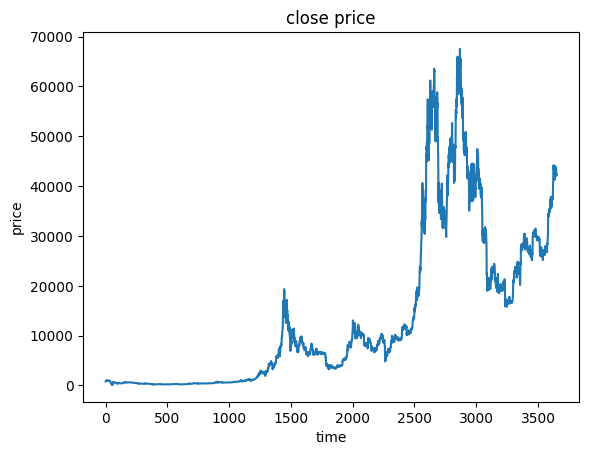

In [37]:
fig1 = plt.figure()
plt.plot(close_price)
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [38]:
#define method to extract X and y
def extract_data(data, time_step):
    X = []
    y = []
    for i in range(len(data) - time_step):
        X.append([a for a in data[i: i + time_step]])
        y.append(data[i + time_step])
    X = np.array(X)
    #转化成RNN格式 (样本数,timestep, 每个数据的维度(特征数))
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y)
    return X, y

In [70]:
time_step = 30
#define X and y
X, y = extract_data(close_price_norm, time_step)
print(X[0, :, :], X.shape, y.shape, type(X), type(y))
print(time_step)

[[0.01208241]
 [0.01268957]
 [0.01309533]
 [0.0136936 ]
 [0.01502638]
 [0.01499676]
 [0.01303017]
 [0.0139024 ]
 [0.01387575]
 [0.01418377]
 [0.01488718]
 [0.01391721]
 [0.01366694]
 [0.01361363]
 [0.01393794]
 [0.01352774]
 [0.01324193]
 [0.01341223]
 [0.01413934]
 [0.01415711]
 [0.01424893]
 [0.01408307]
 [0.01398237]
 [0.01357217]
 [0.01423115]
 [0.01491235]
 [0.013972  ]
 [0.01381207]
 [0.01370841]
 [0.0139409 ]] (3622, 30, 1) (3622,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
30


In [40]:
#set up the model

model = Sequential()
#add RNN layer
model.add(SimpleRNN(units=50, input_shape=(time_step, 1), activation='relu'))
#add output layer
model.add(Dense(units=1, activation='linear'))
#configure the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
print(X.shape, y.shape)
print(time_step)

(3622, 30, 1) (3622,)
30


In [42]:
#train the model
model.fit(X, y, batch_size=30, epochs=200)

Epoch 1/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - loss: 0.0161
Epoch 2/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 35s 286ms/step - loss: 2.2482e-04
Epoch 3/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 272ms/step - loss: 3.4604e-04
Epoch 4/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 264ms/step - loss: 2.7317e-04
Epoch 5/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step - loss: 2.6002e-04
Epoch 6/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 266ms/step - loss: 1.9952e-04
Epoch 7/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 272ms/step - loss: 1.6693e-04
Epoch 8/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step - loss: 1.7132e-04
Epoch 9/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 2.2274e-04
Epoch 10/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - loss: 1.9124e-04
Epoch 11/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 31s 254ms/step - loss: 1.8140e-04
Epoch 12/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 1.6487e-04
Epoch 13/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - loss: 1.5903e-04
Epoch 14/200
122/122 ━━━━

In [72]:
print(time_step)

30


In [44]:
model.save('BTC_predict_test1.h5')
model.save('BTC_predict_test1.keras')

In [45]:
#make prediction on the training data
y_train_predict = model.predict(X) * max(close_price)
y_train = y * max(close_price)

print(y_train_predict.shape)
print(y_train.shape)

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
(3632, 1)
(3632,)


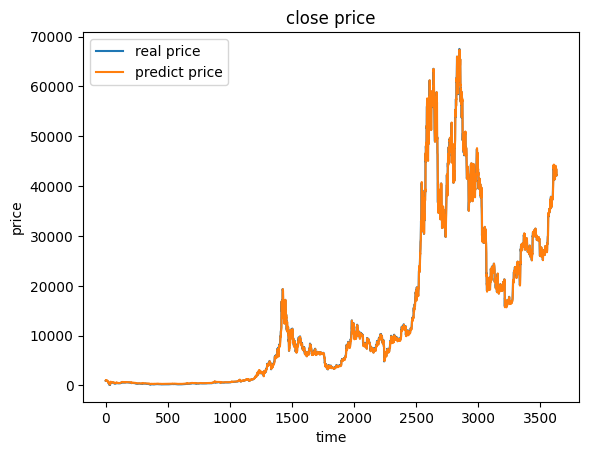

In [46]:
fig2 = plt.figure()
plt.plot(y_train, label='real price')
plt.plot(y_train_predict, label='predict price')
plt.legend()
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [49]:
data_test = pd.read_csv('BTC_test_data.csv')
data_test.head()

# Reverse the order of the DataFrame
data_test = data_test.iloc[::-1].reset_index(drop=True)
# Display the first 5 rows
print(data_test.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data_test.info())

| timeOpen   | Close   | Open    | High    | Low     | volume   | Chg.(%)   |
|:-----------|:--------|:--------|:--------|:--------|:---------|:----------|
| 2024-01-01 | 44183.4 | 42272.5 | 44187   | 42196.7 | 36.30K   | 0.05      |
| 2024-01-02 | 44943.7 | 44182.9 | 45885.4 | 44166   | 97.84K   | 0.02      |
| 2024-01-03 | 42836.1 | 44943.7 | 45492.7 | 40888.3 | 117.65K  | (0.05)    |
| 2024-01-04 | 44157   | 42836.1 | 44744.5 | 42632.8 | 68.05K   | 0.03      |
| 2024-01-05 | 44156.9 | 44163   | 44312.1 | 42629   | 68.07K   | 0.00      |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  169 non-null    object 
 1   Close     169 non-null    float64
 2   Open      169 non-null    float64
 3   High      169 non-null    float64
 4   Low       169 non-null    float64
 5   volume    169 non-null    object 
 6   Chg.(%)   169 non-null    object 

In [54]:
price_test = data_test.loc[:, 'Close']
price_test_norm = price_test / max(close_price)

X_test_norm, y_test_norm = extract_data(price_test_norm, time_step)

print(X_test_norm.shape, y_test_norm.shape)
print(X_test_norm[0])

(149, 20, 1) (149,)
[[0.65429845]
 [0.6655575 ]
 [0.63434669]
 [0.6539075 ]
 [0.65390602]
 [0.65110717]
 [0.65050594]
 [0.69544884]
 [0.68311024]
 [0.69051903]
 [0.68635631]
 [0.63434373]
 [0.63457178]
 [0.61820522]
 [0.62952794]
 [0.6389285 ]
 [0.63334859]
 [0.61149095]
 [0.61675248]
 [0.61745442]]


In [73]:
print(time_step)

30


In [55]:
y_test_predict = model.predict(X_test_norm) * max(close_price)
y_test = y_test_norm * max(close_price)
print(y_test_predict[0], y_test[0])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[41677.383] 41583.2


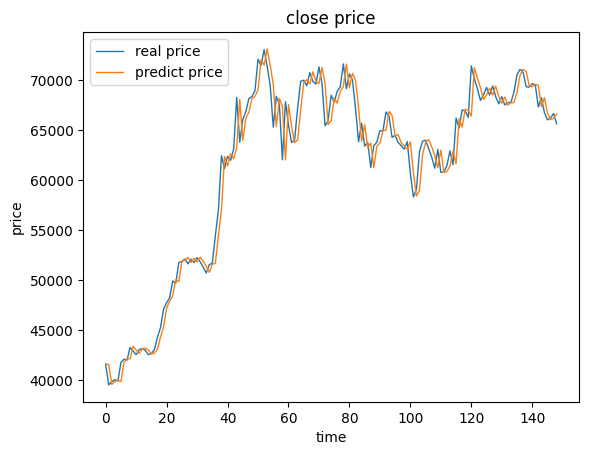

In [56]:
fig3 = plt.figure()
plt.plot(y_test, label='real price',linewidth = 1)
plt.plot(y_test_predict, label='predict price', lw = 1)
plt.legend()
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [57]:
result_y_test = y_test.reshape(-1, 1)
result_y_predict = y_test_predict

print(y_test.shape, result_y_test.shape, y_test_predict.shape)

result = np.concatenate((result_y_test, result_y_predict), axis=1)
print(result.shape)

result = pd.DataFrame(result, columns=['real_price_test', 'predict_price_test'])
result.to_csv('BTC_predict_test.csv')

(149,) (149, 1) (149, 1)
(149, 2)


In [59]:
#进行迭代预测
data_30d = pd.read_csv('BTC_30D.csv')
data_30d.head()

# Reverse the order of the DataFrame
data_30d = data_30d.iloc[::-1].reset_index(drop=True)
# Display the first 5 rows
print(data_30d.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data_30d.info())

| timeOpen   | Close   | Open    | High    | Low     | volume   | Chg.(%)   |
|:-----------|:--------|:--------|:--------|:--------|:---------|:----------|
| 2024/5/19  | 66279.1 | 66919   | 67662.5 | 65937.3 | 36.19K   | -0.01     |
| 2024/5/20  | 71422.7 | 66278.3 | 71482.8 | 66076.5 | 112.66K  | 0.08      |
| 2024/5/21  | 70139.9 | 71430.5 | 71872   | 69181.7 | 108.56K  | -0.02     |
| 2024/5/22  | 69155.4 | 70141   | 70593.4 | 69024.3 | 65.08K   | -0.01     |
| 2024/5/23  | 67975.7 | 69166.3 | 70041   | 66578.1 | 89.45K   | -0.02     |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  30 non-null     object 
 1   Close     30 non-null     float64
 2   Open      30 non-null     float64
 3   High      30 non-null     float64
 4   Low       30 non-null     float64
 5   volume    30 non-null     object 
 6   Chg.(%)   30 non-null     float64
d

In [77]:
price_30d = data_30d.loc[:, 'Close']
price_30d_norm = price_30d / max(close_price)

print(price_30d_norm.shape)
print(time_step) #不懂 不知道为什么前面是(n,20,1) #草,原来是眼瞎了
print(type(price_30d_norm))



(30,)
30
<class 'pandas.core.series.Series'>


In [80]:
price_30d_norm = np.array(price_30d_norm)
print(price_30d_norm.shape)
price_30d_norm = price_30d_norm.reshape(1, price_30d_norm.shape[0], 1)
print(price_30d_norm.shape)

(30,)
(1, 30, 1)


In [102]:
#定义函数
def predict_and_update(model, price_30d_norm, num_predictions):
    """
    使用模型进行多次预测，并在每次预测后更新输入数据。

    参数:
        model: 训练好的预测模型。
        price_30d_norm: 初始的归一化价格数据，形状为 (1, 30, 1)。
        num_predictions: 要进行的预测次数。

    返回:
        所有预测结果组成的列表。
    """
    predictions = []
    for _ in range(num_predictions):
        # 预测
        predict_30d_norm = model.predict(price_30d_norm)

        # 转换 predict_30d_norm 的形状并拼接
        price_30d_norm = np.concatenate([price_30d_norm, predict_30d_norm.reshape(1, 1, 1)], axis=1)

        # 删除第一个元素
        price_30d_norm = price_30d_norm[:, 1:]

        predictions.append(predict_30d_norm * max(close_price))

    return predictions

In [133]:
a = predict_and_update(model, price_30d_norm, 365)
a = np.array(a)
a = a.flatten()
indexed_a = list(enumerate(a))
print(a)
a = np.array(indexed_a)
print(a[:, 0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

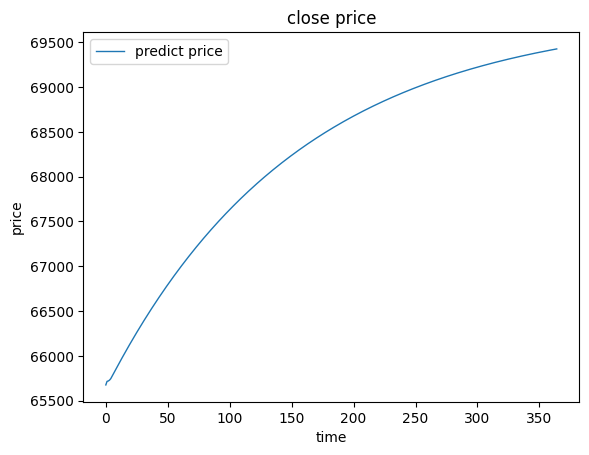

In [134]:
fig4 = plt.figure()
#plt.plot(y_test, label='real price')
plt.plot(a[:, 0], a[:, 1], label='predict price', lw = 1)
plt.legend()
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()